In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import warnings
import joblib
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torch
from torchtuples.practical import MLPVanilla
from sklearn.linear_model import LassoCV
from torchtuples import optim as ttoptim
from sklearn.model_selection import train_test_split
import csv
from torch.utils.data import DataLoader, TensorDataset

from pycox.models.loss import CoxPHLoss
import torchtuples as tt
import matplotlib.pyplot as plt


In [2]:

# Suppress all warnings
warnings.filterwarnings('ignore')


In [3]:

model_used = 'CoxPH'
selection_method = 'lasso'

Light_GBM_global = [
    "flair_t1ce_t2",
    # "flair_t1ce_t2",
    # "flair",
    # "flair_t1ce",
    # "flair_t1ce"
]
Light_GBM_local = [
    "flair_t1ce_t2",
    # "flair_t1ce",
    # "flair",
    # "t2",
    # "flair_t1ce",
]

In [4]:
train_path = '../dataset/MICCAI_BraTS2020_TrainingData/survival_info.csv'
val_path = '../dataset/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv'

In [5]:

def ensure_directory_exists(filepath):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)


In [6]:
def load_radiomic_features(target_directory, file_name):
    file_path = os.path.join(target_directory, file_name)
    array = np.load(file_path)
    print(f"Array loaded from '{file_path}'")
    return array


In [7]:
def save_model_and_parameters(model, modality_used, mask, params):
    model_dir = f"./models/{selection_method}_feature_selection/CoxPH/{modality_used}/"
    ensure_directory_exists(model_dir)
    model_file = os.path.join(model_dir, 'model.pt')
    params_file = os.path.join(model_dir, 'params.txt')
    mask_file = os.path.join(model_dir, f'{selection_method}_mask.npy')
    
    # Save the model
    model.save_net(model_file)
    
    # Save the parameters
    with open(params_file, 'w') as file:
        file.write(f"Parameters: {params}\n")
    
    # Save the selected features mask
    np.save(mask_file, mask)
    
    print(f"Model, parameters, and {selection_method} mask saved successfully for modality {modality_used}.")

In [8]:
def load_and_combine_features(modality_keys, dataset_type):
    combined_features = []
    for modality in modality_keys:
        features = np.load(f'../local_spatial_Framework/features/{modality}/{dataset_type}/{dataset_type}_backbone_outputs.npy')
        combined_features.append(features)
    return np.concatenate(combined_features, axis=1)


In [9]:
def make_csv(y_pred_validation, modality_used):
    df = pd.read_csv('../dataset/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv')
    validation_ids = df['BraTS20ID'].values
    filename = f"../radiomics_local_global_predictions/{selection_method}_feature_selection/{model_used}/{modality_used}_{model_used}.csv"
    #removing 116 paitents ID from list
    validation_ids = np.delete(validation_ids, 26, axis=0)
    

    ensure_directory_exists(filename)

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Days"])
        for id, day in zip(validation_ids, y_pred_validation):
            writer.writerow([id, int(day)])  # Convert to int if necessary

    print(f"CSV file '{filename}' created successfully.")

In [10]:

def load_features(modality_used):
    base_dir = os.path.join('../Global_extracted_features', modality_used)
    train_features = np.load(os.path.join(base_dir, 'train_features.npy'))
    validate_features = np.load(os.path.join(base_dir, 'validate_features.npy'))
    train_labels = np.load(os.path.join(base_dir, 'train_labels.npy'))
    return train_features, validate_features, train_labels

In [11]:
def train_model(train_features, validate_features, train_labels, modality_used):
    print("train_features shape:", train_features.shape)
    print("validate_features shape:", validate_features.shape)
    print("train_labels shape:", train_labels.shape)

    print("train_features dtype:", train_features.dtype)
    print("validate_features dtype:", validate_features.dtype)
    print("train_labels dtype:", train_labels.dtype)

    print("Any NaN in train_features:", np.isnan(train_features).any())
    print("Any NaN in validate_features:", np.isnan(validate_features).any())
    print("Any NaN in train_labels:", np.isnan(train_labels).any())

    print("Any inf in train_features:", np.isinf(train_features).any())
    print("Any inf in validate_features:", np.isinf(validate_features).any())
    print("Any inf in train_labels:", np.isinf(train_labels).any())
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    validate_features_scaled = scaler.transform(validate_features)
    
    print(f"Size of features before Lasso: {train_features_scaled.shape}")

    # Lasso Feature Selection
    lasso = LassoCV(cv=5, random_state=42, max_iter=100, alphas=np.logspace(-4, -0.5, 30)).fit(train_features_scaled, train_labels)
    
    mask = lasso.coef_ != 0
    train_features_selected = train_features_scaled[:, mask]
    validate_features_selected = validate_features_scaled[:, mask]

    if train_features_selected.shape[1] == 0:
        print(f"No features selected for modality {modality_used}. Skipping this combination.")
        return

    print(f"Size of features after Lasso: {train_features_selected.shape}")

    # Convert data to PyTorch tensors
    x_train = torch.FloatTensor(train_features_selected)
    x_val = torch.FloatTensor(validate_features_selected)
    y_train = torch.FloatTensor(train_labels)

    # Create dummy event indicators (all 1 for this example, adjust if you have actual event data)
    events_train = torch.ones_like(y_train)

    # Define the model
    in_features = train_features_selected.shape[1]
    out_features = 1
    net = tt.practical.MLPVanilla(in_features, [32, 32], out_features, batch_norm=True, dropout=0.1)

    model = CoxPH(net, tt.optim.Adam)

    # Train the model
    batch_size = 256
    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping()]
    
    # Use tt.tuplefy to create the correct data structure
    y_train = (y_train, events_train)
    train_data = (x_train, y_train)

    log = model.fit(*train_data, batch_size, epochs, callbacks, verbose=True)

    # Make predictions
    _ = model.compute_baseline_hazards()
    surv = model.predict_surv_df(x_val)
    # print(surv)
    
    # Convert survival predictions to days
    y_pred_validation = surv.median().values

    make_csv(y_pred_validation, modality_used)
    
    # Save the model, parameters, and Lasso mask
    save_model_and_parameters(model, modality_used, mask, {'epochs': epochs, 'batch_size': batch_size})
    return surv
    

In [12]:

radiomic_train_features = load_radiomic_features("../radiomics features/all", "radiomics_train.npy")
radiomic_validation_features = load_radiomic_features("../radiomics features/all", "radiomics_validate.npy")

print("radiomic_train_features", radiomic_train_features.shape)
print("radiomic_validation_features", radiomic_validation_features.shape)


Array loaded from '../radiomics features/all/radiomics_train.npy'
Array loaded from '../radiomics features/all/radiomics_validate.npy'
radiomic_train_features (235, 400)
radiomic_validation_features (28, 400)


In [13]:
preds = None

In [14]:


for modality_used_global, modality_used_local in zip(Light_GBM_global, Light_GBM_local):
    modality_key_local = modality_used_local.split("_")
    modality_keys_list_global_features = modality_used_global.split("_")
    print(f"\nLoading and combining features... \n local-{modality_used_local}\n global-{modality_used_global}")

    local_train_features = load_and_combine_features(modality_key_local, 'train')
    local_validation_features = load_and_combine_features(modality_key_local, 'validation')
    
    global_train_features, global_validate_features, train_labels = load_features(modality_used_global)
    
    print("global_train_features", global_train_features.shape, "local_train_features", local_train_features.shape)
    print("global_validate_features", global_validate_features.shape, "local_validation_features", local_validation_features.shape)

    local_global_training_features = np.concatenate((global_train_features, local_train_features), axis=1)
    local_global_validation_features = np.concatenate((global_validate_features, local_validation_features), axis=1)

    train_labels = np.delete(train_labels, 98, axis=0)
    local_global_training_features = np.delete(local_global_training_features, 98, axis=0)
    local_global_validation_features = np.delete(local_global_validation_features, 26, axis=0)

    training_all_features = np.concatenate((local_global_training_features, radiomic_train_features), axis=1)
    validation_all_features = np.concatenate((local_global_validation_features, radiomic_validation_features), axis=1)

    print("combining all")
    print("radiomics_local_global_training", training_all_features.shape)
    print("radiomics_local_global_validation", validation_all_features.shape)

    modality_used = 'global_' + modality_used_global + '___local_' + modality_used_local

    
    preds = train_model(training_all_features, validation_all_features, train_labels,  modality_used)



Loading and combining features... 
 local-flair_t1ce_t2
 global-flair_t1ce_t2
global_train_features (236, 744) local_train_features (236, 192)
global_validate_features (29, 744) local_validation_features (29, 192)
combining all
radiomics_local_global_training (235, 1336)
radiomics_local_global_validation (28, 1336)
train_features shape: (235, 1336)
validate_features shape: (28, 1336)
train_labels shape: (235,)
train_features dtype: float64
validate_features dtype: float64
train_labels dtype: int64
Any NaN in train_features: False
Any NaN in validate_features: False
Any NaN in train_labels: False
Any inf in train_features: False
Any inf in validate_features: False
Any inf in train_labels: False
Size of features before Lasso: (235, 1336)


Size of features after Lasso: (235, 670)
0:	[0s / 0s],		train_loss: 4.6861
1:	[0s / 0s],		train_loss: 4.5483
2:	[0s / 0s],		train_loss: 4.5014
3:	[0s / 0s],		train_loss: 4.4593
4:	[0s / 0s],		train_loss: 4.4496
5:	[0s / 0s],		train_loss: 4.4251
6:	[0s / 0s],		train_loss: 4.4169
7:	[0s / 0s],		train_loss: 4.3997
8:	[0s / 0s],		train_loss: 4.3765
9:	[0s / 0s],		train_loss: 4.3482
CSV file '../radiomics_local_global_predictions/lasso_feature_selection/CoxPH/global_flair_t1ce_t2___local_flair_t1ce_t2_CoxPH.csv' created successfully.
Model, parameters, and lasso mask saved successfully for modality global_flair_t1ce_t2___local_flair_t1ce_t2.


In [15]:
type(preds)

pandas.core.frame.DataFrame

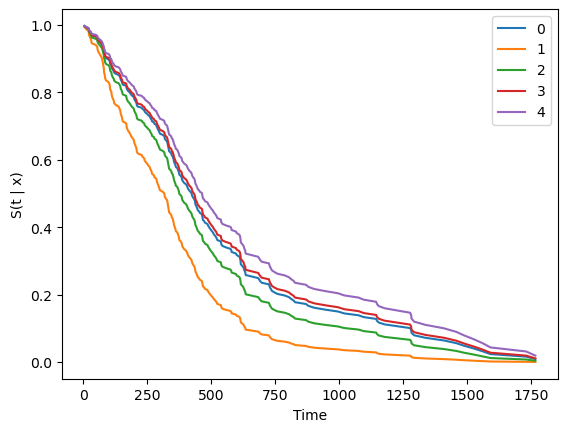

In [16]:
surv = preds
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [17]:
y_pred_validation = surv.median().values

In [18]:
y_pred_validation

array([0.57119006, 0.379576  , 0.51501364, 0.5851003 , 0.62566656,
       0.58830094, 0.3867753 , 0.09744779, 0.49184817, 0.40671533,
       0.5117872 , 0.45100576, 0.5898542 , 0.51751846, 0.5661451 ,
       0.44374728, 0.58425   , 0.3739985 , 0.50429434, 0.66667545,
       0.        , 0.2627846 , 0.56220573, 0.        , 0.        ,
       0.        , 0.43416378, 0.4158431 ], dtype=float32)

In [19]:
   # Convert to survival days
surv_days = np.array([surv.index[np.where(s >= 0.5)[0][0]] if np.any(s >= 0.5) else surv.index[-1] for s in surv.values.T])


In [20]:
surv_days

array([   5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5., 1767.,    5.,    5., 1767., 1767., 1767.,    5.,
          5.], dtype=float32)